## Keras/TF -version, BERT -> News classification

# Important, Finding with this Keras.

In [ ]:
# first step, downgrade tensorflow a little bit
# so we can use the models hub for BERT
#!pip install -U "tensorflow-text==2.15.*"
#!pip install -U "tf-models-official==2.15.*"




# I got error with Mac os while installing 2.15, I tried with different and updated version as well.
# After spending enough time on it I INSTALLED scucceffly but then it was givine me other error for updrade , # Then i try 2.12.0 along 2.17 as well
# Screenshot also attached.
# I also spend time on it but could not get success then I moved on bert_torch approach



#ERROR: Could not find a version that satisfies the requirement tensorflow-macos==2.15.0 (from versions: 2.12.0)
#ERROR: No matching distribution found for tensorflow-macos==2.15.0


![Screenshot 2025-04-13 at 17.17.24.png](<attachment:Screenshot 2025-04-13 at 17.17.24.png>)
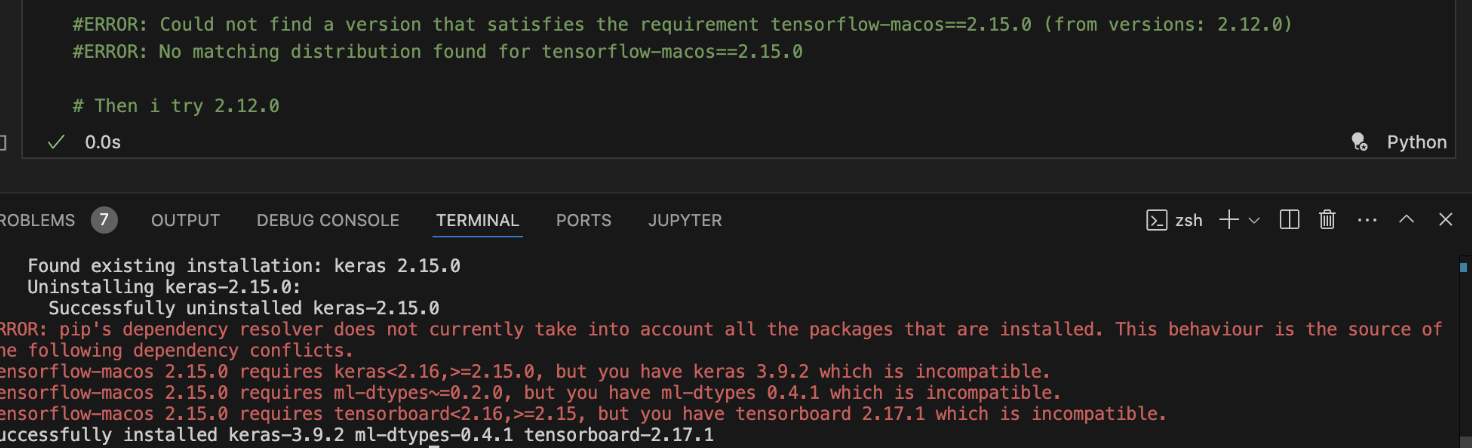

### Imports

In [2]:
# importing libraries
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.
from keras.utils import to_categorical
from official.nlp import optimization  # to create AdamW optimizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'tensorflow_hub'

### Load and process the data as in the Torch-version

In [ ]:
# first step: Connect your Google Drive into this notebook
# tip: use the file explorer on the left, and click the Google Drive-icon to connect
data_file_path = "/content/drive/MyDrive/AdvancedML2025/news_categories.csv"

df = pd.read_csv(data_file_path)

In [ ]:
# quick check, does the data load?
df.head(3)

In [ ]:
# combine headline with short_description (to have a bit more data)
df['headline'] = df['headline'] + " - " + df['short_description']

In [ ]:
# select only "category" and "headline" columns
# category is going to be the target
df = df[['category', 'headline']]

In [ ]:
# DOUBLE-CHECK THE ORDER AFTER TARGET VARIABLE HAS BEEN ENCODED TO INTEGERS
TEXT_LABELS = ['BUSINESS', 'ENTERTAINMENT', 'SPORTS', 'WORLD NEWS']

In [ ]:
# List of categories to filter
categories_to_filter = TEXT_LABELS

# Filter rows where category is in the list
df = df[df['category'].isin(categories_to_filter)]

In [ ]:
# this phase usually takes time, since its made by CPU
# might be a better idea to save the processed version to another csv-file
# import nltk for stopword removal
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import multiprocessing as mp

# remove stopwords
nltk.download('stopwords')

# define a function which we can apply to our data
# => remove English stopwords (filler words)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return ' '.join(words)

# apply the function to the 'headline' column
df['headline'] = df['headline'].apply(remove_stopwords)

## Process the category-variable into numeric representation

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'category' column
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Display the encoded DataFrame
df.tail()

In [ ]:
df = df[['category_encoded', 'headline']]

In [ ]:
df

### Split the data train/test

In [ ]:
# split 20% to test, 80% for training
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
#removing punctuations and other irrelevant characters.
X_train = df_train['headline']

le = LabelEncoder()
y_train = df_train['category_encoded']
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=len(TEXT_LABELS))

X_test = df_test['headline']
y_test = df_test['category_encoded']
y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=len(TEXT_LABELS))

# model training parameters

In [ ]:
# epochs and batch sizes
epochs = 5
batch_size = 32
eval_batch_size = 32

# define steps per eopch etc. related variables
train_data_size = df.shape[0]
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)

# learning rate and optimizer
lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type="adamw")

## Build the whole model

In [ ]:
def build_model(num_classes, optimizer, max_len=512):
  # input of our model, string -datatype
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")

  # load the BERT-model preprocessor
  preprocessor = hub.KerasLayer(
      "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessing")

  # add the preprocessing layer to the input
  encoder_inputs = preprocessor(text_input)

  # the actual BERT-model
  encoder = hub.KerasLayer(
      "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2",
      trainable=True, name="BERT-tiny")

  # wrap up the BERT -model into the output of the whole model
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(64, activation="relu")(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  out = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(net)

  # wrap up the whole model
  model = tf.keras.Model(text_input, out)
  model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

  return model



In [ ]:
# use our helper function the create the actual model
model = build_model(num_classes=len(TEXT_LABELS), optimizer=optimizer)

In [ ]:
model.summary()

## Train the model

In [ ]:
# train the model
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=batch_size,
                    validation_batch_size=eval_batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test),
                    verbose=1)

# Training and error metrics

In [ ]:
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot()
loss_df[['accuracy', 'val_accuracy']].plot()

In [ ]:
# create the test predictions
y_proba = model.predict(X_test, batch_size=eval_batch_size)
y_pred = np.argmax(y_proba, axis=1)

# get actual labels for predictions
y_pred_labels = [TEXT_LABELS[i] for i in le.inverse_transform(y_pred)]
y_true_labels = [TEXT_LABELS[i] for i in df_test['category_encoded']]

In [ ]:
# print the classification report
print(classification_report(y_true_labels, y_pred_labels))

In [ ]:
 # get one-hot representation of y_true and y_pred
y_true_onehot = pd.get_dummies(y_true_labels).values
y_pred_onehot = pd.get_dummies(y_pred_labels).values

print(f"ROC AUC: {roc_auc_score(y_true_onehot, y_pred_onehot, multi_class='ovr')}")

In [ ]:
sns.heatmap(confusion_matrix(y_true_labels, y_pred_labels), annot=True, fmt='g',
            xticklabels=TEXT_LABELS, yticklabels=TEXT_LABELS)

## Test with some news headlines

In [ ]:
# some example news headlines from the Naive-Bayes -implementation earlier

# "Japanese manufacturing sector union members demand record pay hike in 2025",
# "As Arsenal fizzle out, Liverpool grow stronger - Premier League hits and misses",
# "Timothee Chalamet and Demi Moore among winners at SAG Awards - a major Oscars predictor",
# "Hope for koalas after bushfires - After millions of koalas died in bushfires that swept through Australia, the species now has a glimmer of hope."]

# wrap the data into correct pandas DataFrame-format
test_data = {
    "text": ["As Arsenal fizzle out, Liverpool grow stronger - Premier League hits and misses"]
}

# dataframe for the test headline
new_df = pd.DataFrame.from_dict(test_data)
new_df['text'] = new_df['text'].apply(remove_stopwords)
test_value = new_df['text']

# get the prediction
test_value_prob = model.predict(test_value, batch_size=eval_batch_size)
test_value_pred = np.argmax(test_value_prob, axis=1)

# print the results
print(TEXT_LABELS)
print(test_value_prob)